### Imports

In [1]:
# ML imports
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, make_scorer, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder 
from xgboost import XGBClassifier 

# Data analysis imports
import numpy as np
import pandas as pd

# Data visualization imports
import seaborn as sns
import matplotlib.pyplot as plt 


### Get data

In [2]:
train_df = pd.read_csv('C:\\Users\\Kamen\ML\\Projet-STT-3795\\src\\train_preprocessed_data')
test_df = pd.read_csv('C:\\Users\\Kamen\\ML\\Projet-STT-3795\\src\\test_preprocessed_data')
validation_df = pd.read_csv('C:\\Users\\Kamen\\ML\\Projet-STT-3795\\src\\validation_preprocessed_data')

df = pd.concat([train_df, test_df, validation_df]).reset_index().iloc[:, 2:]
df.rename(columns={'0': 'label'}, inplace=True)

df_without_label = df.iloc[:, 0:-1]

df_without_label

,MFCC_mean_1,MFCC_mean_2,MFCC_mean_3,MFCC_mean_4,MFCC_mean_5,MFCC_mean_6,MFCC_mean_7,MFCC_mean_8,MFCC_mean_9,MFCC_mean_10,...,median_energy,min_energy,max_energy,energy_range,q25_energy,q75_energy,energy_iqr,energy_variability,zero_crossing_rate,low_energy_frame_rate
0,2.157688e-07,-1.192093e-09,-4.827976e-08,1.072884e-08,-4.798174e-08,-1.585484e-07,-1.907349e-08,8.940696e-10,-2.145767e-08,1.192093e-08,...,0.037345,2.265041e-04,0.079646,0.079419,0.014605,0.052177,0.037572,0.724594,0.340000,0.280000
1,2.880891e-07,-4.967054e-08,-3.973643e-08,-1.241763e-09,0.000000e+00,-3.973643e-08,-7.202228e-08,-3.973643e-08,0.000000e+00,1.490116e-08,...,0.060775,4.608796e-03,0.133238,0.128629,0.041807,0.078045,0.036238,0.488379,0.291667,0.208333
2,2.037395e-07,4.118139e-08,2.844767e-08,-6.502325e-09,-2.384186e-08,7.586046e-08,-2.004884e-08,1.950697e-08,3.251163e-08,-1.408837e-08,...,0.021503,4.646347e-04,0.114373,0.113909,0.011146,0.036039,0.024893,0.586159,0.363636,0.327273
3,-1.739811e-07,7.732494e-08,-1.822372e-08,8.054681e-09,-9.665618e-09,1.288749e-08,-2.094217e-08,4.832809e-09,-2.416405e-08,-8.860150e-09,...,0.033641,2.054304e-05,0.095782,0.095761,0.021047,0.060261,0.039214,0.460019,0.324324,0.216216
4,2.781550e-07,-1.655685e-08,3.311369e-08,9.106265e-09,2.317958e-08,2.649095e-08,-1.324548e-08,-1.986822e-08,2.649095e-08,-1.986822e-08,...,0.011589,1.277450e-04,0.047214,0.047086,0.003591,0.019345,0.015754,0.397569,0.291667,0.361111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33834,-8.316928e-09,-1.478565e-08,1.478565e-08,-7.392824e-09,1.478565e-08,-6.468721e-09,1.478565e-08,-1.293744e-08,5.544618e-09,5.544618e-09,...,0.010918,6.751887e-18,0.108211,0.108211,0.002563,0.026813,0.024251,1.196073,0.286822,0.472868
33835,-3.833195e-07,7.433453e-08,1.335966e-08,1.712777e-09,1.019102e-08,1.096177e-08,8.015797e-08,-7.193664e-08,-1.164688e-08,3.691035e-08,...,0.010180,9.358834e-07,0.091771,0.091770,0.002963,0.023323,0.020360,0.700669,0.287356,0.436782
33836,-7.663454e-08,-2.554485e-08,8.514950e-09,-1.702990e-08,1.277242e-08,8.514950e-09,-1.277242e-08,-1.490116e-08,1.064369e-09,-8.514950e-09,...,0.004112,0.000000e+00,0.216372,0.216372,0.000022,0.074126,0.074104,0.939229,0.232143,0.642857
33837,-5.337048e-07,5.352254e-08,2.729345e-08,5.778001e-09,-3.649264e-09,6.082107e-09,1.338063e-08,9.427265e-09,-3.284337e-08,1.642169e-08,...,0.005400,1.110373e-05,0.049721,0.049709,0.001521,0.013512,0.011991,0.413974,0.306122,0.479592


### Principal components

In [3]:
def get_PCs(dataframe, percentage_variance):
    print()
    scaler = StandardScaler()
    scaled_df = scaler.fit_transform(dataframe)
    print(f'Scaled_df Mean = {np.mean(scaled_df)},\nScaled_df Std = {np.std(scaled_df)}')


    pca_T = PCA()
    pca_T.fit_transform(scaled_df)
    ev = pca_T.explained_variance_
    print()
    print(f'Total variance = {sum(ev)}')

    pca = PCA(percentage_variance/100)
    principal_components = pca.fit_transform(scaled_df)
    explained_variance = pca.explained_variance_
    percentage = sum(pca.explained_variance_ratio_)
    print(f'Real percentage = {percentage}')
    print(f'Variance for {round(percentage*100, 2)}% = {sum(explained_variance)}')
    print(f'Number of PCs for {round(percentage*100, 2)}% = {len(explained_variance)}')
    print(f'Attribute lost = {len(scaled_df[0]) - len(explained_variance)}')
    names = pca.get_feature_names_out()
    return pd.DataFrame(data=principal_components, columns=names)


In [4]:
df_pca = get_PCs(df_without_label, 99)
df_pca['label'] = df['label']
df_pca


Scaled_df Mean = -2.584758141888949e-10,
Scaled_df Std = 0.9900823995480058

Total variance = 149.00440333353052
Real percentage = 0.9906802950257512
Variance for 99.07% = 147.61572625459803
Number of PCs for 99.07% = 112
Attribute lost = 40


,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,...,pca103,pca104,pca105,pca106,pca107,pca108,pca109,pca110,pca111,label
0,-6.846301,-0.794682,-1.536361,-0.531060,2.674738,1.151737,-2.316436,-0.744755,0.449961,1.436357,...,-0.054221,0.581620,0.447038,-0.148556,-0.208436,0.306970,0.228184,-0.135247,-0.156935,Arabic
1,-8.282369,0.601282,1.343966,3.208460,-0.263810,-0.786909,-1.818669,1.830671,-0.074072,-0.043485,...,0.188950,0.162407,0.548263,0.079200,-0.581986,0.120321,0.680845,-0.774546,0.429966,Arabic
2,-5.752032,-3.889077,-1.147494,-2.447550,4.389365,1.152855,-0.986151,0.311142,1.527196,0.388732,...,-0.719330,0.670119,0.330638,0.269435,0.676214,-0.375446,-0.041232,0.161506,-0.112769,Arabic
3,-6.314026,-3.055212,1.878134,-2.668336,3.235905,-2.264787,0.945493,-0.419671,-1.164477,-0.402846,...,-0.641084,0.976203,0.321082,0.050084,-0.551730,0.135528,-0.507154,0.136573,0.398881,Arabic
4,-1.284617,0.438320,-0.941597,-0.899166,-2.784148,1.721596,-0.669662,-0.319959,-2.254108,-0.759143,...,0.217607,-0.087759,0.210774,0.151235,-0.471020,0.273360,-0.549753,0.122128,-0.202348,Arabic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33834,5.577451,-2.457812,-0.526243,-0.550048,1.357615,-2.594622,1.930523,-0.054834,0.454744,-0.579236,...,0.155616,0.044566,0.014128,-0.783504,-0.211985,0.162698,0.077321,-0.093820,0.074553,Welsh
33835,2.076398,-1.192741,-2.040670,2.131349,-4.868499,1.696290,-0.571228,-0.309808,0.910451,0.043693,...,0.658748,0.240613,-0.067128,0.230721,0.184112,-0.359243,-0.151368,-0.227087,-0.070353,Welsh
33836,1.860997,-11.443138,7.657294,2.652043,2.277993,3.663964,5.045110,-1.099924,0.908964,-0.573526,...,-0.057513,0.528139,1.264590,-0.324757,0.731826,-0.821705,-0.284468,0.364663,0.082091,Welsh
33837,3.265824,-5.027013,-0.434763,-1.530173,-0.567788,2.469110,3.299886,-0.164852,-0.540913,1.821883,...,-0.476444,0.433360,0.471973,0.262737,0.147500,0.119994,-0.312292,0.336557,-0.383642,Welsh


### Models

RFC and SVM

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(df_pca.iloc[:, 0:-1], df['label'], stratify=df['label'], test_size=0.3, random_state=42)

"""
# Model initialization
svm = SVC(verbose=3)
random_forest = RandomForestClassifier(verbose=3)
nn = MLPClassifier(verbose=3)

# Models fiting
print("Training SVM")
svm.fit(X_train, Y_train)
print("Training RFC")
random_forest.fit(X_train, Y_train)
#nn.fit(X_train, Y_train)

# Models prediction
svm_predictions = svm.predict(X_test)
random_forest_predictions = svm.predict(X_test)
#nn_predictions = svm.predict(X_test)
"""


'\n# Model initialization\nsvm = SVC(verbose=3)\nrandom_forest = RandomForestClassifier(verbose=3)\nnn = MLPClassifier(verbose=3)\n\n# Models fiting\nprint("Training SVM")\nsvm.fit(X_train, Y_train)\nprint("Training RFC")\nrandom_forest.fit(X_train, Y_train)\n#nn.fit(X_train, Y_train)\n\n# Models prediction\nsvm_predictions = svm.predict(X_test)\nrandom_forest_predictions = svm.predict(X_test)\n#nn_predictions = svm.predict(X_test)\n'

XGBClassifier

In [6]:
xgbc = XGBClassifier()

# Languages -> int
label_encoder = LabelEncoder()
Y_train = label_encoder.fit_transform(Y_train)
Y_test = label_encoder.fit_transform(Y_test)

xgbc.fit(X_train, Y_train)
xgbc_predictions = xgbc.predict(X_test)
xgbc_cm = confusion_matrix(label_encoder.inverse_transform(Y_test),label_encoder.inverse_transform(xgbc_predictions))
xgbc_report = classification_report(label_encoder.inverse_transform(Y_test),label_encoder.inverse_transform(xgbc_predictions))
xgbc_accuracy = accuracy_score(label_encoder.inverse_transform(Y_test),label_encoder.inverse_transform(xgbc_predictions))
print(xgbc_cm)
print(xgbc_report)

[[ 7  1 12 ...  4  1  0]
 [ 1 11  0 ...  2  2  0]
 [ 3  0 52 ...  2  0  1]
 ...
 [ 2  2  4 ...  9  1  1]
 [ 2  0  4 ...  0  6  0]
 [ 0  3  1 ...  1  1  7]]
                   precision    recall  f1-score   support

           Arabic       0.08      0.08      0.08        91
           Basque       0.20      0.17      0.19        63
           Breton       0.27      0.44      0.34       117
          Catalan       0.23      0.10      0.14        61
    Chinese_China       0.14      0.07      0.09        60
 Chinese_Hongkong       0.43      0.30      0.35        67
   Chinese_Taiwan       0.13      0.21      0.16       100
          Chuvash       0.37      0.35      0.36        72
            Czech       0.13      0.12      0.13        81
          Dhivehi       0.29      0.32      0.31        65
            Dutch       0.13      0.16      0.15        85
          English       0.21      0.12      0.15        58
        Esperanto       0.05      0.03      0.04        64
         Estonian

GridSearch

In [7]:
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [80, 100, 200],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1], 
    'alpha' : [1e-5, 1e-2, 0.1, 1, 100], 
}

xgbc = XGBClassifier()

# Accuracy = (TP + TN)/(TP + TN + FP + FN) -> num pred correct / total number of pred
grid_search = RandomizedSearchCV(estimator=xgbc, param_grid=param_grid, scoring='f1', cv=5, verbose=1)
grid_search.fit(X_train, Y_train)
# Print the best parameters and the best F1 score
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best F1 score: {grid_search.best_score_}")

# Evaluate on the test set
best_estimator = grid_search.best_estimator_
y_pred = best_estimator.predict(X_test)
test_f1_score = f1_score(Y_test, y_pred)

print(f"Test F1 Score: {test_f1_score}")

XGBClassifier evaluation

0.22369976359338062
[[ 7  1 12 ...  4  1  0]
 [ 1 11  0 ...  2  2  0]
 [ 3  0 52 ...  2  0  1]
 ...
 [ 2  2  4 ...  9  1  1]
 [ 2  0  4 ...  0  6  0]
 [ 0  3  1 ...  1  1  7]]


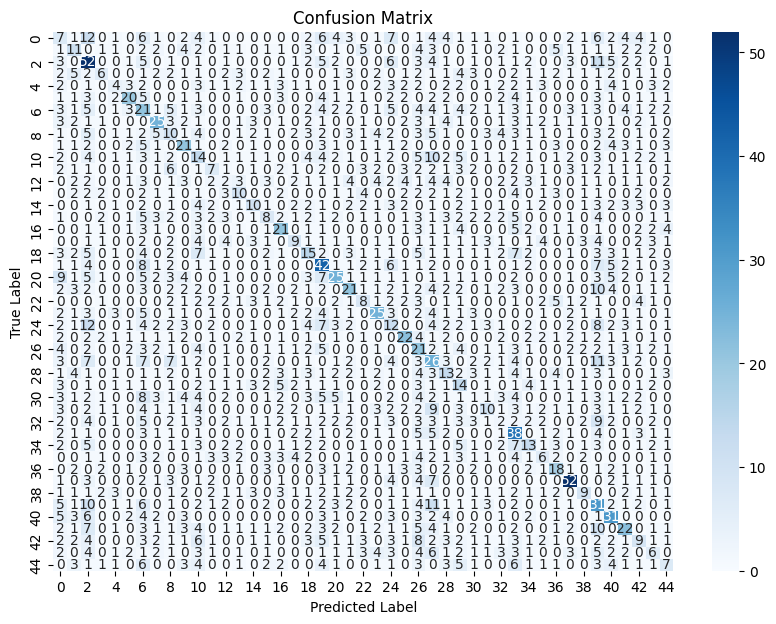

                   precision    recall  f1-score   support

           Arabic       0.08      0.08      0.08        91
           Basque       0.20      0.17      0.19        63
           Breton       0.27      0.44      0.34       117
          Catalan       0.23      0.10      0.14        61
    Chinese_China       0.14      0.07      0.09        60
 Chinese_Hongkong       0.43      0.30      0.35        67
   Chinese_Taiwan       0.13      0.21      0.16       100
          Chuvash       0.37      0.35      0.36        72
            Czech       0.13      0.12      0.13        81
          Dhivehi       0.29      0.32      0.31        65
            Dutch       0.13      0.16      0.15        85
          English       0.21      0.12      0.15        58
        Esperanto       0.05      0.03      0.04        64
         Estonian       0.26      0.19      0.22        54
           French       0.27      0.16      0.20        61
          Frisian       0.15      0.12      0.13       

In [8]:
xgbc_cm = confusion_matrix(label_encoder.inverse_transform(Y_test),label_encoder.inverse_transform(xgbc_predictions))
xgbc_report = classification_report(label_encoder.inverse_transform(Y_test),label_encoder.inverse_transform(xgbc_predictions))
xgbc_accuracy = accuracy_score(label_encoder.inverse_transform(Y_test),label_encoder.inverse_transform(xgbc_predictions))
print(xgbc_accuracy)
print(xgbc_cm)
# Plotting the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(xgbc_cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
print(xgbc_report)